# Campfire Detection Pipeline for Solar Orbiter HRIEUV174 Data
The goal of this notebook is to try out different detection algorithms for detecting small campfires in Solar Orbiter's Extreme UV Imager (EUV) data. You'll find
- functions implementing detection algorithms
- helper functions for handling, storing and visualizing data.

In particular, the output includes
- single frame showcases of detections and filters
- .csv output files from the filtered dataframes
- mp4 files with or without the detections from a selected algorithm
- event statistics.

## Setup

First, let's import the required modules and set a global root path variable.

In [3]:
# import all important libraries
from __future__ import annotations
from typing import List, Tuple, Dict, Any, Optional, Iterable, TypedDict
import numpy as np
import pandas as pd
from skimage.measure import label, regionprops
from skimage.morphology import disk, binary_dilation
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import glob
from pathlib import Path
import sunpy
from sunpy.map import MapSequence
import astropy.units as u
import pickle
from sunpy.visualization.colormaps import cm
import imageio.v2 as imageio
from sklearn.cluster import DBSCAN

# helpful aliases
MapSeq = MapSequence
BBox = Tuple[int, int, int, int]
DetectionDict = Dict[str, Any]
DetectionRow = pd.Series
DetectionFrame = pd.DataFrame

# make typed dictionary for type hinting
class CampfireData(TypedDict):
    frame: int
    x: float
    y: float
    area_px: int
    area_Mm2: float
    intensity: float
    bbox: BBox

# GLOBAL VARIABLE: ROOT PATH
root_dir = Path().resolve().parents[0]
print(f"Root directory: {root_dir}")

c:\Users\David\solar_orbiter_campfires\solo-campfires\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Root directory: C:\Users\David\solar_orbiter_campfires\solo-campfires


## Helper Functions
- **load_dataset():** Loads the specified dataset (from pickle cache if possible) and saves the sequence in a variable.
- **save_to_csv():** Saves a data frame to a .csv file in the ../results/csv folder with the specified name.
- **showcase_detections():** Showcases the detections from a specified algorithm on a specified frame using bboxes to overlay on top of the detections.
- **make_movie():** Renders all frames from the sequence at a specified framerate, with or without detections, and saves the file in "../results/video".

In [4]:
def load_dataset(dataset: str) -> MapSeq:
    """ 
    Loads the specified data set (from a pickle cache if possible) and saves the sunpy MapSequence in a variable.
    """
    raw_dir = root_dir / "data" / "raw" / f"{dataset}"
    processed_dir = root_dir / "data" / "processed"
    processed_dir.mkdir(parents=True, exist_ok=True) # make directory if it doesn't exist already
    cache_file = processed_dir / f"{dataset}_sequence.pkl"

    # load or render sequence if necessary
    if cache_file.exists():
        sequence = pickle.load(open(cache_file, "rb")) # binary read mode
        print(f"Cached sequence loaded ({len(sequence)} maps)")
    else:
        files = sorted(glob.glob(str(raw_dir / "*.fits")))
        sequence = sunpy.map.Map(files, sequence=True)
        pickle.dump(sequence, open(cache_file, "wb")) # binary write mode
        print(f"First load --> saved cache ({len(sequence)} maps)")
    return sequence
    
#=================================================================================================================================================

def save_to_csv(df: pd.DataFrame, file_name: str) -> None:
    results_dir = root_dir / "results" / "csv"
    results_dir.mkdir(parents = True, exist_ok = True) # make the directory if it doesn't exist already, otherwise do nothing
    
    file_path = results_dir / f"{file_name}.csv"

    df.to_csv(file_path, index = False) # no need for indices inside .csv file
    print(f"Saved {len(df)} detections to: {file_path}")

#=================================================================================================================================================
def showcase_detections(sequence: MapSeq, 
                        sample_frame: int, 
                        df: pd.DataFrame, 
                        factor: float = 10.0,
                        vmin_pct: float = 0.05,
                        vmax_pct: float = 99.5,
                        dpi: int = 200,) -> None: 
    """ 
    Displays a sample frame from the map sequence with bounding boxes (scaled by "factor" for visibility) over the detections from a dataframe.
    """

    # create plot
    cmap = cm.cmlist["solar orbiterhri_euv174"]
    m = sequence[sample_frame]
    data = m.data.flatten()
    plt.figure(figsize=(6, 6), dpi = dpi)

    # improve contrast
    vmin = np.percentile(data, vmin_pct)
    vmax = np.percentile(data, vmax_pct)

    fig, ax = plt.subplots(1, 2, figsize=(12,7), dpi = dpi, gridspec_kw={'wspace': 0.05})
    data = m.data

    # original frame
    ax[0].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax, origin = "lower")
    ax[0].set_title(f"Original Frame {sample_frame}")
    ax[0].axis("off")

    # detections
    ax[1].imshow(data, cmap = cmap, vmin = vmin, vmax = vmax, origin = "lower")
    ax[1].set_title(f"Detections in Frame {sample_frame}")
    ax[1].axis("off")

    plt.suptitle(f"Solar Orbiter / EUI HRI-EUV-174\n{sequence[sample_frame].date.isot}", color = "black", fontsize = 14, y=0.9)

    # add detections with bboxes
    detections = df[df["frame"] == sample_frame]

    for _, row in detections.iterrows():
        centroid_x = row["x"]
        centroid_y = row["y"]

        min_row, min_col, max_row, max_col = row["bbox"] 
        width = max_col - min_col
        height = max_row - min_row
        area = width * height

        # scale the boxes for better visibility of detections
        if area <= 3: 
            scalar = factor * 4
        elif 3 < area <= 20:
            scalar = factor * 2
        elif 20 < area <= 40:
            scalar = factor
        elif 40 < area <= 60:
            scalar = factor * 0.8
        else: 
            scalar = factor * 0.45
                    
        width *= scalar
        height *= scalar

        # compute bottom left corner so centroid is in the center
        bottom_left_x = centroid_x - (width / 2)
        bottom_left_y = centroid_y - (height / 2)

        bbox = patches.Rectangle(
            (bottom_left_x, bottom_left_y),
            width, height,
            facecolor = "none",
            edgecolor = "lightblue",
            linewidth = 1
        )
        ax[1].add_patch(bbox) # gca = get current axes
        
    plt.axis("off")
    plt.show()

#=================================================================================================================================================

def make_movie(sequence: MapSeq, 
               df: Optional[pd.DataFrame] = None, 
               file_name: str = "movie", 
               fps: int = 10, 
               factor: float = 10, 
               show_detections: bool = False, 
               vmin_pct: float = 0.01, 
               vmax_pct: float = 99.99, 
               use_global_clipping: bool = False) -> None:
    """ 
    Renders a .mp4 files of the map sequence, with or without scaled bounding boxes over the detections.

    Parameters
    ----------
    sequence: sunpy.map.MapSequence
        Input data sequence. 
    df: Optional[pd.DataFrame] = None
        Dataframe with the detections to be displayed, if desired.
    file_name: str
        File name (automatically generated from parameters by default).
    fps: int, default 10
        Frames per second for the movie.
    factor: float, default 10.0
        Scales the bounding boxes of detections by a factor for better visibility.
    show_detections: bool, default False
        Just renders the map sequence without bboxes if show_detections == False.
    vmin_pct, vmax_pct: float
        Percentage defining the data range the colormap covers. Smaller range = higher contrast.
    use_global_clipping: bool, default False
        True: Determines vmin and vmax from around 50 sample frames and uses those values globally.
        False: Calculates vmin and vmax for each frame individually.
    Returns
    -------
    .mp4 file in the specified results folder.
    """


    # show length of input sequence
    print(f"Using {len(sequence)} frames for video.")

    # Set up paths
    output_file = root_dir / "results" / "video" / f"{file_name}.mp4"
    output_file.parent.mkdir(parents = True, exist_ok = True)
    
    # colormap
    cmap = cm.cmlist["solar orbiterhri_euv174"] # other options: check https://docs.sunpy.org/en/stable/reference/visualization.html

    if show_detections:
        print(f"Visualizing {len(df)} total detections with {factor}x scaled, centered bounding boxes.")

    # Global Clipping Filter
    if use_global_clipping:
        sample = [m.data.flatten() for m in sequence[::max(1, len(sequence)//50)]]
        all_samples = np.concatenate(sample)
        vmin = np.percentile(all_samples, vmin_pct)
        vmax = np.percentile(all_samples, vmax_pct)
        print(f"Global scaling: vmin={vmin:.1f}, vmax={vmax:.1f}")
    else:
        vmin = vmax = None # will be computed per frame later
    

    # H.264 Encoder + YUV 4:2:0 color space with planar layout
    with imageio.get_writer(output_file, fps=fps, codec="libx264", pixelformat="yuv420p") as writer:
        for idx, m in enumerate(sequence):
            data = m.data # extract 2D image np.array with pixel intensities
            detections = df[df["frame"] == idx]

            if not use_global_clipping:
                vmin, vmax = np.percentile(data, (vmin_pct, vmax_pct))

            fig = plt.figure(figsize = (8, 8), facecolor = "black", dpi = 200) # black background
            ax = plt.subplot()
            ax.imshow(data, cmap = cmap, vmin = vmin, vmax = vmax, origin = "lower") # origin: .fits have origin at lower left corner
            ax.set_title(f"Solar Orbiter / EUI HRI_EUV_174\n{m.date.isot}", color = "white", fontsize = 12)
            ax.set_axis_off()

            if show_detections and df is not None:
                # Draw scaled and centered bboxes
                for _, row in detections.iterrows():
                    centroid_x = row["x"]
                    centroid_y = row["y"]

                    min_row, min_col, max_row, max_col = row["bbox"] 
                    width = max_col - min_col
                    height = max_row - min_row
                    area = width * height

                    # scale the boxes for better visibility of detections
                    if area <= 3: 
                        scalar = factor * 4
                    elif 3 < area <= 20:
                        scalar = factor * 2
                    elif 20 < area <= 40:
                        scalar = factor
                    elif 40 < area <= 60:
                        scalar = factor * 0.8
                    else: 
                        scalar = factor * 0.45
                        
                    width *= scalar
                    height *= scalar

                    # compute bottom left corner so centroid is in the center
                    bottom_left_x = centroid_x - (width / 2)
                    bottom_left_y = centroid_y - (height / 2)

                    bbox = patches.Rectangle(
                        (bottom_left_x, bottom_left_y),
                        width, height,
                        facecolor = "none",
                        edgecolor = "lightblue",
                        linewidth = 2
                    )
                    ax.add_patch(bbox)

            plt.tight_layout(pad = 0.5)

            # force matplotlib to render the figure into a buffer in memory
            fig.canvas.draw() 

            # buffer_rgba() returns [width x height x (R, G, B, A)] --> [:, :, :3] --> drop alpha (not needed with imageio)
            frame = np.array(fig.canvas.renderer.buffer_rgba())[:, :, :3]
            writer.append_data(frame)

            plt.close(fig) # free memory (!)
            print(f"Frame {idx + 1} / {len(sequence)} rendered...", end = "\r")
            
    print(f"\nDone! Movie saved to: {output_file}")

## Detection Algorithms

##### The next cells contain all the detection functions we can play around with, along with functions to help handle and visualize the produced datasets. In particular, this includes:
- **sigma_threshold():** Calculates the mean brightness $\mu$ and standard deviation $\sigma$ of all pixels in a frame, then applies a minimum threshold for detection of $\mu + n\sigma$ (either per frame or global with ~50 frame average).
- **filter_by_area():** Filter detections by minimum and maximum pixel area.
- **build_masks(), apply_masks(), visualize_mask():** build_masks() creates per-frame masks covering the brightest x% of pixels, which can be visualized with visualize_mask(). Any events within the mask can be removed from a dataframe with apply_masks().
- **build_event_catalog():** Uses scikit.learn's DBSCAN to identify spatiotemporal clusters, filters by lifetime and area, then returns an event catalog (with event statistics) and a per-frame detection data frame for visualization.



In [5]:
def sigma_threshold(sequence: MapSeq, sigma: float = 3, per_frame: bool = False) -> pd.DataFrame:
    """
    Set a baseline for detections using a simple sigma-clipping threshold (mean + x sigma).
    
    Parameters
    ----------
    sequence : sunpy.map.MapSequence
        Input data sequence.
    sigma : float, default 3.0
        Number of standard deviations above the background.
    per_frame : bool, default False
        Compute threshold per frame instead of sampling around 50 frames for global values.

    Returns
    -------
    pandas.DataFrame
        DataFrame with one row per detection.
    """
    if not per_frame:
        # compute mean and std from at least 50 sample frames 
        sample = [m.data.astype(float).ravel() for m in sequence[::max(1, len(sequence)//50)]]
        all_samples = np.concatenate(sample)
        low, high = np.percentile(all_samples, [1, 99]) # remove extreme 1%
        clean_samples = all_samples[(all_samples >= low) & (all_samples <= high)]
        mean, std = clean_samples.mean(), clean_samples.std()

    detections = []
    for i, m in enumerate(sequence):
        # only a small angle approximation // TODO: implement foreshortening to correct for spherical geometry.
        pixel_area_Mm2 = (m.scale.axis1.to(u.rad / u.pixel) * m.scale.axis2.to(u.rad / u.pixel) * m.observer_coordinate.radius.to(u.km)**2).value / 1_000_000
        img = m.data.astype(float)
        if per_frame:
            mean, std = img.mean(), img.std()
        mask = img > (mean + (sigma * std))
        lab = label(mask)
        props = regionprops(lab, intensity_image=img)

        for p in props:
            detections.append({
                "frame": i,
                "x": p.centroid[1],
                "y": p.centroid[0], # swapped, because (y, x) in .fits format
                "area_px": p.area,
                "area_Mm2": p.area * pixel_area_Mm2,
                "intensity": p.max_intensity,
                "bbox": p.bbox,
            })
    df = pd.DataFrame(detections)

    if len(df) == 0:
        print("No detections found.")
        return df
    else:
        print(f"{len(df)} detections found.")
        return df



In [6]:
def filter_by_area(df: pd.DataFrame, min_area_px: int =3, max_area_px: int =250) -> pd.DataFrame:
    """ 
    Filters a dataframe for detections with areas inside the range (min_area, max_area).

    Parameters
    ----------
    df: pd.DataFrame
        Input dataframe.
    min_area_px, max_area_px: int
        Minimum/maximum area in pixels.

    Returns
    -------
    pd.DataFrame
        Filtered data frame.
    """
    
    filtered_df = df[(df["area_px"] >= min_area_px) & (df["area_px"] <= max_area_px)].reset_index(drop = True)
    print(f"Before area filter: {len(df)}")
    print(f"After area filter: {len(filtered_df)}")
    return filtered_df

In [7]:
def build_mask(sequence: MapSeq, frame: int, bright_pct: float = 99, dilation: int = 3, min_area: int = 150) -> np.ndarray:
    """ 
    Builds a boolean mask of the brightest X% of pixels in a frame.

    Parameters
    -----------
    sequence: sunpy.map.MapSequence
        Input map sequence. 
    frame: int
        Frame to be masked.
    bright_pct: float, default 99
        Percentage above which pixels should be masked out.
    dilation: int, default 3
        Expands mask slightly for smoother edges.
    min_area: int, default 150
        Minimum area (in pixels) of a detected patch to be added to the mask.
    
    Returns
    -------
    np.ndarray
        n-dimensional array of boolean values (True = masked out).
    """
    m = sequence[frame]
    data = m.data.copy()
    
    threshold = np.percentile(data, bright_pct)
    bright_mask = data > threshold
    
    labeled = label(bright_mask)
    mask = np.zeros_like(bright_mask, dtype=bool)
    
    for region in regionprops(labeled):
        if region.area >= min_area:
            mask[labeled == region.label] = True
    
    if dilation > 0:
        mask = binary_dilation(mask, disk(int(round(dilation))))
    
    return mask

def build_masks(sequence: MapSeq, bright_pct: float = 99, dilation: int = 3, min_area: int = 150) -> List[np.ndarray]:
    """ 
    Builds masks for an entire sequence and stores them in a list.
    """
    return [build_mask(sequence, frame, bright_pct, dilation, min_area) for frame in range(len(sequence))]

def apply_masks(df: pd.DataFrame, masks: List[np.ndarray]) -> pd.DataFrame:
    """ 
    Applies a list of masks to a dataframe, removing detections inside masked regions.

    Parameters
    ----------
    df: pd.DataFrame
        Input data frame.
    masks: List[np.ndarray]
        List of boolean n-dimensional arrays.
    
    Returns
    -------
    pd.DataFrame
        Filtered data frame.
    """

    if "frame" not in df.columns:
        raise ValueError("df must have a 'frame' column")
    
    df = df.copy()
    masked_out = np.zeros(len(df), dtype=bool)
    
    for frame, mask in enumerate(masks):
        sub_df = df[df["frame"] == frame]
        if len(sub_df) == 0:
            continue
            
        height, width = mask.shape
        y = sub_df["y"].round().astype(int)
        x = sub_df["x"].round().astype(int)
        
        in_bounds = (x >= 0) & (x < width) & (y >= 0) & (y < height)
        valid_y = y[in_bounds]
        valid_x = x[in_bounds]
        
        masked_out[sub_df.index[in_bounds]] = mask[valid_y, valid_x]
    
    df["masked_out"] = masked_out
    masked_df = df[~df["masked_out"]].drop(columns=["masked_out"])
    print(f"Before mask: {len(df)}")
    print(f"After mask: {len(masked_df)}")
    return masked_df

# helper function to visualize mask
def visualize_mask(sequence: MapSeq, frame: int, mask: np.ndarray) -> None:
    """ 
    Displays a sample frame (left) and the masked out regions (right).
    """

    m = sequence[frame]
    data = m.data.copy()

    fig, ax = plt.subplots(1, 2, figsize=(12,5), dpi = 150)

    # original frame
    ax[0].imshow(data, cmap = "Grays_r", origin = "lower")
    ax[0].set_title(f"Original Frame {frame}")
    ax[0].axis("off")

    # mask overlay
    ax[1].imshow(data, cmap = "Grays_r", origin = "lower")
    ax[1].imshow(mask, cmap = "Reds", alpha = 0.4, origin = "lower")
    ax[1].set_title(f"Masked Regions {frame}")
    ax[1].axis("off")

    plt.show()


In [8]:
def merge_detections(df: pd.DataFrame, radius: int) -> pd.DataFrame:
    """ 
    Merges detections within radius into one detection for each frame using DBSCAN.

    Parameters:
    df: pd.DataFrame
        Input data frame.
    radius: int
         Radius inside of which detections get counted as one event.

    Returns
    -------
    pd.DataFrame
        Filtered data frame.
    """
    merged_rows = []

    for frame in df.frame.unique():
        d = df[df["frame"] == frame].copy()

        if len(d) == 0:
            continue
        if len(d) == 1:
            p = d.iloc[0]
            merged_rows.append(p)
            continue

        coords = d[["x", "y"]].values

        # cluster detections based on spatial proximity
        clustering = DBSCAN(eps = radius, min_samples = 1).fit(coords)
        d["cluster_id"] = clustering.labels_

        # merge detections withing each cluster
        for _, group in d.groupby("cluster_id"):
            merged = {
                "frame": frame,
                "x": group["x"].mean(),
                "y": group["y"].mean(), # choose center of cluster as coordinates
                "area_px": group["area_px"].sum(), # add areas of individual detections (assuming no overlap)
                "area_Mm2": group["area_Mm2"].sum(),
                "intensity": group["intensity"].max() # choose max intensity
            }
            
            bboxes = np.array(list(group["bbox"]))
            merged["bbox"] = (
                bboxes[:,0].min(), # [:,0] means all rows, column 0, so bottom
                bboxes[:,1].min(), # left
                bboxes[:,2].max(), # top
                bboxes[:,3].max(), # right
            )

            merged_rows.append(merged)

    filtered_df = pd.DataFrame(merged_rows).reset_index(drop = True)
    print(f"Before merging: {len(df)}")
    print(f"After merging: {len(filtered_df)}")
    print(f"Removed: {len(df) - len(filtered_df)}")
    return filtered_df

In [9]:
def build_event_catalog(df: pd.DataFrame,
    cadence_seconds: float,
    spatial_eps: float = 5,
    temporal_eps_frames: float = 3,
    min_samples: int = 2,
    min_lifetime_seconds: float = 10,
    max_lifetime_seconds: Optional[float] = 500.0,
    max_area_Mm2: float = 15.0,
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Build a catalog of solar campfires from per-frame detections using spatiotemporal DBSCAN clustering followed by lifetime filtering
    to identify and characterize campfire events.

    Parameters
    ----------
    df : pd.DataFrame
        Per-frame detections with columns: frame, x, y, area_px, area_Mm2, intensity, bbox
    spatial_eps : float
        Spatial clustering radius for DBSCAN in pixels
    temporal_eps_frames : float
        How close in time two events must be to be part of the same cluster (maximum gap in frames)
    min_samples : int
        Minimum detections required to form a cluster
    min_lifetime_seconds : float
        Minimum event duration to keep
    max_lifetime_seconds : float, optional
        Maximum event duration (None = no upper limit)
    cadence_seconds : float
        Time between frames in seconds
    max_area_Mm2 : float
        Maximum total area to qualify as campfire
        
    Returns
    -------
    catalog_df : pd.DataFrame
        Event-level catalog with one row per campfire (summary statistics)
    detections_df : pd.DataFrame
        Per-frame detections with columns: event_id, frame, x, y, bbox, area_Mm2, intensity
        (for use with visualization functions like make_movie())
    """

    print(f"Starting with {len(df)} per-frame detections")

    # 1. Spatiotemporal DBSCAN clustering
    # Scale temporal dimension: temporal_scale_factor converts frames to "pseudo-pixels"
    # so that temporal_eps_frames <=> spatial_eps distance
    temporal_scale_factor = spatial_eps / temporal_eps_frames
    
    X = np.column_stack([
        df["x"].values,
        df["y"].values,
        df["frame"].values * temporal_scale_factor
    ])

    db = DBSCAN(
        eps = spatial_eps,
        min_samples = min_samples,
        metric = "euclidean",
        n_jobs = -1 # use all available CPU cores
    ).fit(X)

    df = df.copy()
    df["cluster_id"] = db.labels_

    n_clusters = len(set(db.labels_)) - (1 if -1 in db.labels_ else 0)
    n_noise = list(db.labels_).count(-1)
    print(f"DBSCAN --> {n_clusters} clusters + {n_noise} noise points")

    # 2. Compute cluster statistics for filtering
    stats = df[df["cluster_id"] >= 0].groupby("cluster_id").agg(
        frame_min=("frame", "min"),
        frame_max=("frame", "max"),
        n_det=("frame", "count"),
        total_area_Mm2=("area_Mm2", "sum"),
    )
    
    stats["lifetime_frames"] = stats["frame_max"] - stats["frame_min"] + 1
    stats["lifetime_seconds"] = stats["lifetime_frames"] * cadence_seconds

    # 3. Filter by lifetime and area
    min_frames = min_lifetime_seconds / cadence_seconds
    max_frames = np.ceil(max_lifetime_seconds / cadence_seconds) if max_lifetime_seconds else np.inf
    
    good_ids = stats[
        (stats["lifetime_frames"] >= min_frames) &
        (stats["lifetime_frames"] <= max_frames) &
        (stats["total_area_Mm2"] <= max_area_Mm2)
    ].index

    df = df[df["cluster_id"].isin(good_ids)].copy()
    print(f"After lifetime/area filter --> {len(good_ids)} events remain")

    # 4. Build two outputs: event catalog + per-frame detections
    catalog = []
    per_frame_detections = []

    for new_id, (cluster_id, group) in enumerate(df.groupby("cluster_id"), start=1):
        group = group.sort_values("frame")

        # Temporal properties
        frames = group["frame"].values
        start_f, end_f = frames.min(), frames.max()
        lifetime_frames = end_f - start_f + 1
        lifetime_s = lifetime_frames * cadence_seconds

        # Spatial bounding box (covering entire event / cluster)
        x_min, x_max = group["x"].min(), group["x"].max()
        y_min, y_max = group["y"].min(), group["y"].max()
        width_px = x_max - x_min + 1
        height_px = y_max - y_min + 1

        # Intensity and area statistics
        peak_intensity = group["intensity"].max()
        mean_intensity = group["intensity"].mean()
        total_area_Mm2 = group["area_Mm2"].sum()
        mean_detection_area_Mm2 = group["area_Mm2"].mean()

        # Event-level catalog entry
        catalog.append({
            "event_id": int(new_id),
            "n_detections": len(group),
            
            # Temporal
            "frame_start": int(start_f),
            "frame_end": int(end_f),
            # total duration (including gaps)
            "total_lifetime_frames": int(lifetime_frames),
            "total_lifetime_seconds": float(lifetime_s),
            "active_frames": len(group),
            "active_seconds": len(group) * cadence_seconds,
            "duty_cycle": float(len(group) / lifetime_frames) if lifetime_frames > 0 else 0.0,

            # Spatial - centroid
            "x_centroid": float(group["x"].mean()),
            "y_centroid": float(group["y"].mean()),
            "x_std": float(group["x"].std(ddof=0) or 0.0),
            "y_std": float(group["y"].std(ddof=0) or 0.0),
            
            # Spatial - bounding box
            "bbox_x1": float(x_min),
            "bbox_y1": float(y_min),
            "bbox_x2": float(x_max),
            "bbox_y2": float(y_max),
            "bbox_width_px": float(width_px),
            "bbox_height_px": float(height_px),
            
            # Intensity
            "peak_intensity": float(peak_intensity),
            "mean_intensity": float(mean_intensity),
            
            # Area
            "total_area_Mm2": float(total_area_Mm2),
            "mean_detection_area_Mm2": float(mean_detection_area_Mm2),
            "total_area_km2": float(total_area_Mm2 * 1_000_000),
            "mean_detection_area_km2": float(mean_detection_area_Mm2 * 1_000_000),
            
            # Original cluster ID (for debugging)
            "original_cluster_id": int(cluster_id)
        })
        
        # Per-frame detections (for visualization)
        for _, detection in group.iterrows():
            per_frame_detections.append({
                "event_id": int(new_id),
                "frame": int(detection["frame"]),
                "x": float(detection["x"]),
                "y": float(detection["y"]),
                "bbox": detection["bbox"],
                "area_Mm2": float(detection["area_Mm2"]),
                "intensity": float(detection["intensity"]),
            })

    catalog_df = pd.DataFrame(catalog)
    catalog_df = catalog_df.sort_values("frame_start").reset_index(drop=True)
    
    detections_df = pd.DataFrame(per_frame_detections)
    detections_df = detections_df.sort_values(["frame", "event_id"]).reset_index(drop=True)

    # 5. Summary statistics
    print(f"\n{'-'*60}")
    print(f"Final campfire catalog: {len(catalog_df)} events")
    if len(catalog_df) > 0:
        print(f"Total lifetime range: {catalog_df['total_lifetime_seconds'].min():.1f} - "
              f"{catalog_df['total_lifetime_seconds'].max():.1f} s")
        print(f"Mean lifetime: {catalog_df['total_lifetime_seconds'].mean():.1f} s")
    print(f"Per-frame detections for visualization: {len(detections_df)}")
    print(f"{'-'*60}\n")

    return catalog_df, detections_df

## Playground
First, load a dataset.

In [10]:
dataset = "20200530"
sequence = load_dataset(dataset)

Cached sequence loaded (50 maps)


In the next cells, you can play around with these algorithms. They are separated so you can tune individual parameters without having to compute everything from scratch in each iteration.

In [11]:
sigma = 3.425
df: pd.DataFrame[CampfireData] = sigma_threshold(sequence, sigma, per_frame=True)

72022 detections found.


Before mask: 72022
After mask: 4590


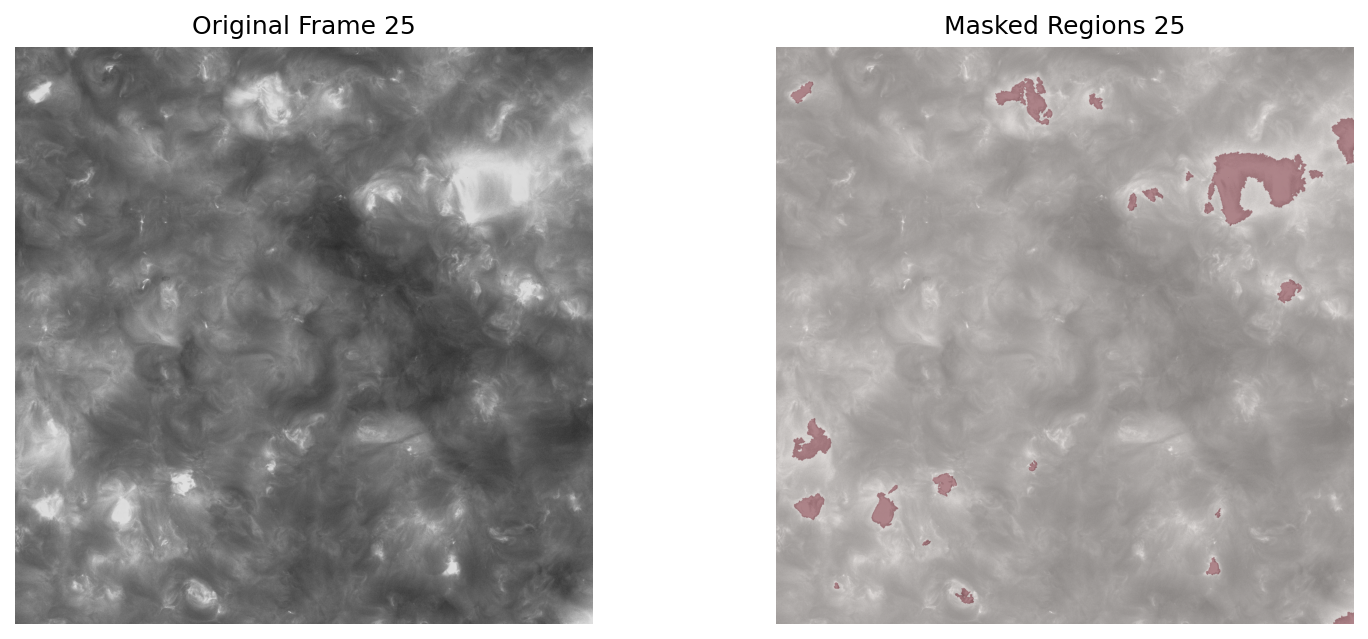

In [12]:
masks = build_masks(sequence, 97.5, dilation = 2, min_area = 150)
df_masked = apply_masks(df, masks)
visualize_mask(sequence, 25, masks[49])

In [13]:
merged_df = merge_detections(df_masked, radius = 16)

Before merging: 4590
After merging: 2766
Removed: 1824


In [14]:
final_df, detections = build_event_catalog(merged_df,
    spatial_eps=8,
    temporal_eps_frames = 3,     
    min_samples=1,
    min_lifetime_seconds=5,
    max_lifetime_seconds=500,
    cadence_seconds=5.0,          
    max_area_Mm2=15,
)

Starting with 2766 per-frame detections
DBSCAN --> 642 clusters + 0 noise points
After lifetime/area filter --> 622 events remain

------------------------------------------------------------
Final campfire catalog: 622 events
Total lifetime range: 5.0 - 250.0 s
Mean lifetime: 18.8 s
Per-frame detections for visualization: 2206
------------------------------------------------------------



In [15]:
save_to_csv(final_df, "test9")

Saved 622 detections to: C:\Users\David\solar_orbiter_campfires\solo-campfires\results\csv\test9.csv


<Figure size 1500x1500 with 0 Axes>

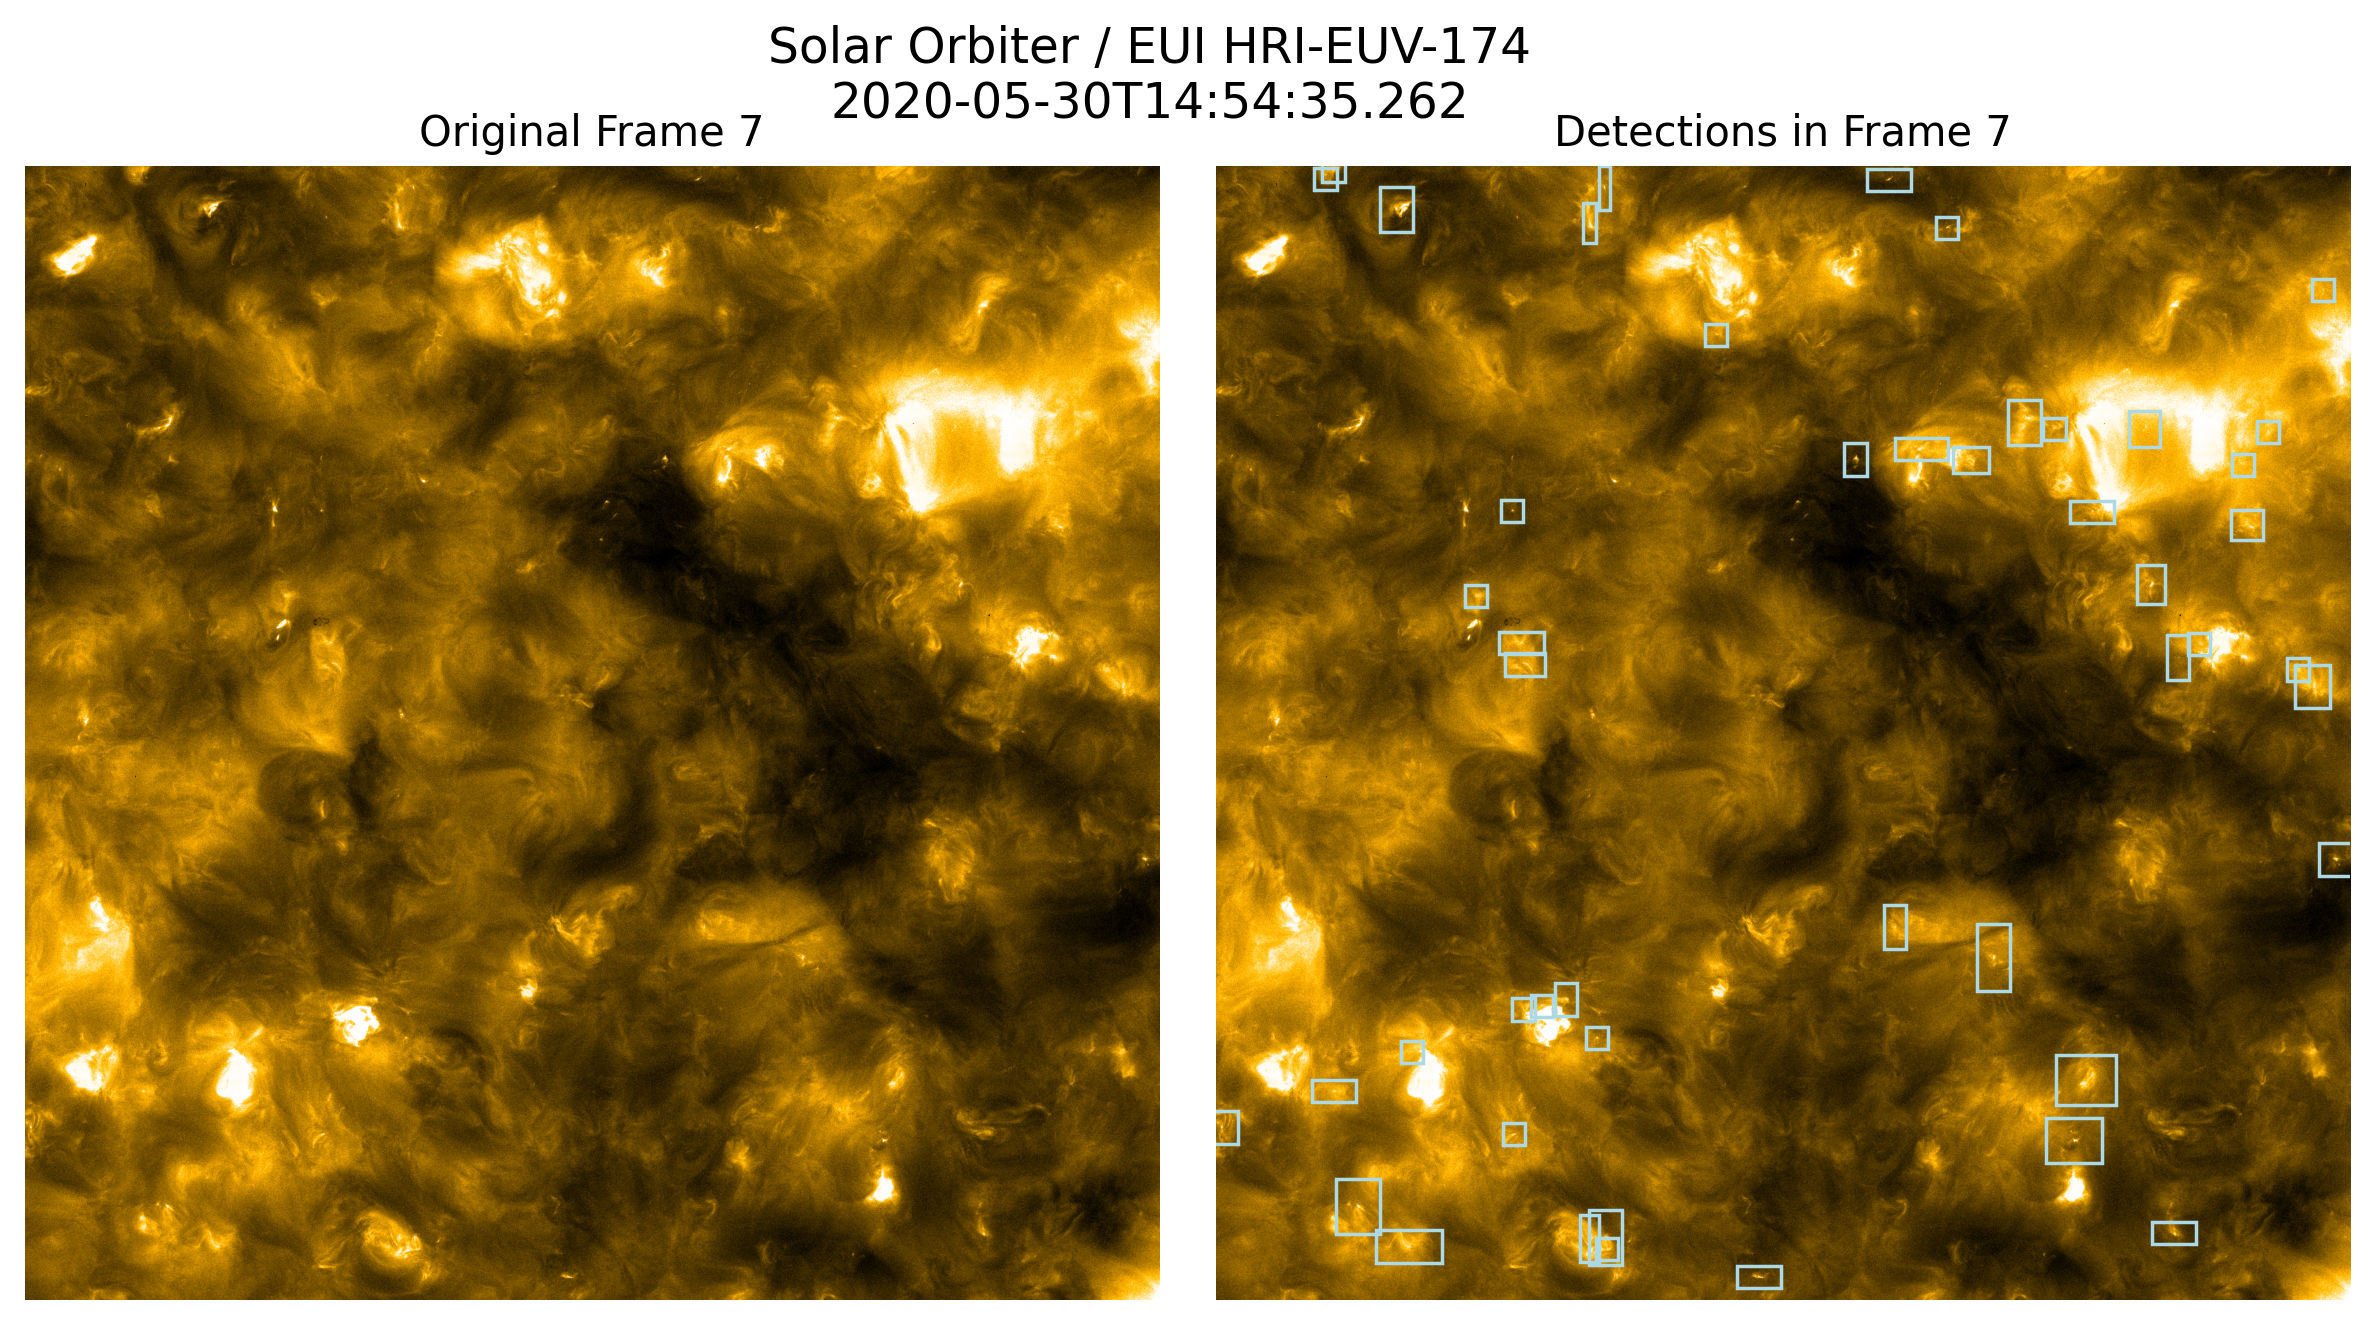

In [16]:
frame = 7
showcase_detections(sequence, frame, detections, 10, 0.1, 99.9, 250)

Here, you can make a movie.

In [18]:
make_movie(sequence, detections, "test2", fps = 7, vmin_pct=0.5, vmax_pct = 99.5, show_detections = True)

Using 50 frames for video.
Visualizing 2206 total detections with 10x scaled, centered bounding boxes.
Frame 50 / 50 rendered...
Done! Movie saved to: C:\Users\David\solar_orbiter_campfires\solo-campfires\results\video\test2.mp4
